In [ ]:
# ======================
# 1. Kaggle Download + Data Loading & Advanced Augmentation
# ======================
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from albumentations import Compose, Resize, HorizontalFlip, RandomBrightnessContrast, GaussNoise, CLAHE, HueSaturationValue

# ---- Set up Kaggle API ----
import json
kaggle_json_path = "/content/kaggle.json"  # <- Update if needed
assert os.path.exists(kaggle_json_path), "kaggle.json not found. Upload it to your Colab environment."

os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!chmod 600 /content/kaggle.json

# ---- Download FIRE Dataset from Kaggle ----
!kaggle datasets download -d phylake1337/fire-dataset

# ---- Extract the dataset ----
with ZipFile("fire-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("/content/fire_dataset")

# ---- Define augmentation pipeline ----
augmentation_pipeline = Compose([
    Resize(224, 224),
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.5),
    CLAHE(p=0.3),
    GaussNoise(p=0.2),
    HueSaturationValue(p=0.3)
])

def load_images_with_labels(base_path):
    fire_dir = os.path.join(base_path, 'fire_images')
    non_fire_dir = os.path.join(base_path, 'non_fire_images')

    data = []
    labels = []

    for label, folder in enumerate([non_fire_dir, fire_dir]):  # 0: non-fire, 1: fire
        for filename in tqdm(os.listdir(folder), desc=f"Loading {folder}"):
            file_path = os.path.join(folder, filename)
            img = cv2.imread(file_path)
            if img is not None:
                augmented = augmentation_pipeline(image=img)
                img_aug = augmented['image']
                data.append(img_aug)
                labels.append(label)

    return np.array(data), np.array(labels)

# Load and augment the data
base_dataset_path = '/content/fire_dataset/fire_dataset'
X_images, y_labels = load_images_with_labels(base_dataset_path)

Dataset URL: https://www.kaggle.com/datasets/phylake1337/fire-dataset
License(s): CC0-1.0


Loading /content/fire_dataset/fire_dataset/non_fire_images: 100%|██████████| 244/244 [00:07<00:00, 32.35it/s]
Loading /content/fire_dataset/fire_dataset/fire_images: 100%|██████████| 755/755 [00:13<00:00, 57.48it/s] 


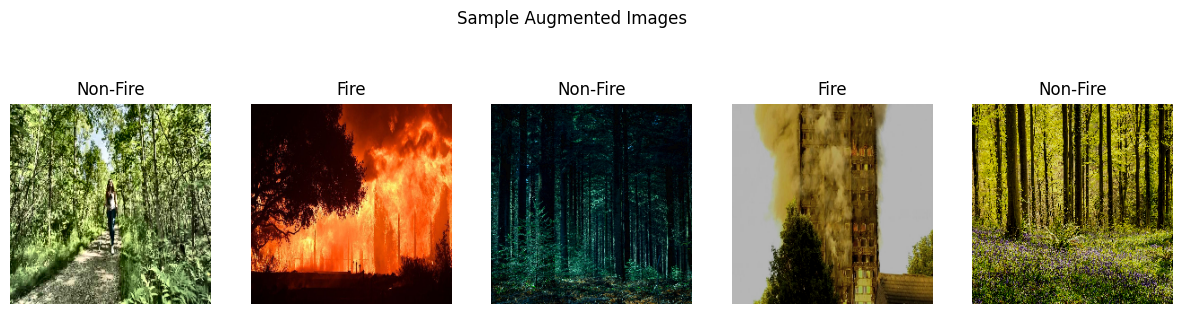

In [ ]:
import matplotlib.pyplot as plt

def visualize_sample_images(images, labels, class_names=["Non-Fire", "Fire"], samples=5):
    plt.figure(figsize=(15, 4))
    for i in range(samples):
        idx = np.random.randint(0, len(images))
        img = images[idx]
        label = labels[idx]
        plt.subplot(1, samples, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(class_names[label])
        plt.axis("off")
    plt.suptitle("Sample Augmented Images")
    plt.show()

visualize_sample_images(X_images, y_labels)


In [ ]:
# ======================
# 2. Feature Extraction Module (Color, Texture, CNN)
# ======================
from skimage.feature import local_binary_pattern
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model

cnn_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_hsv_histogram(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_lbp_texture(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    lbp_hist = lbp_hist.astype("float") / (lbp_hist.sum() + 1e-7)
    return lbp_hist

def extract_cnn_features(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_array = img_to_array(image_rgb)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = cnn_model.predict(img_array, verbose=0)
    return features.flatten()

def extract_all_features_batch(images):
    all_features = []
    for img in tqdm(images, desc="Extracting features"):
        color_feat = extract_hsv_histogram(img)
        texture_feat = extract_lbp_texture(img)
        cnn_feat = extract_cnn_features(img)
        combined = np.concatenate([color_feat, texture_feat, cnn_feat])
        all_features.append(combined)
    return np.array(all_features)

X_features = extract_all_features_batch(X_images)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Extracting features: 100%|██████████| 998/998 [01:47<00:00,  9.32it/s]


Feature shape per image: (998, 25609)


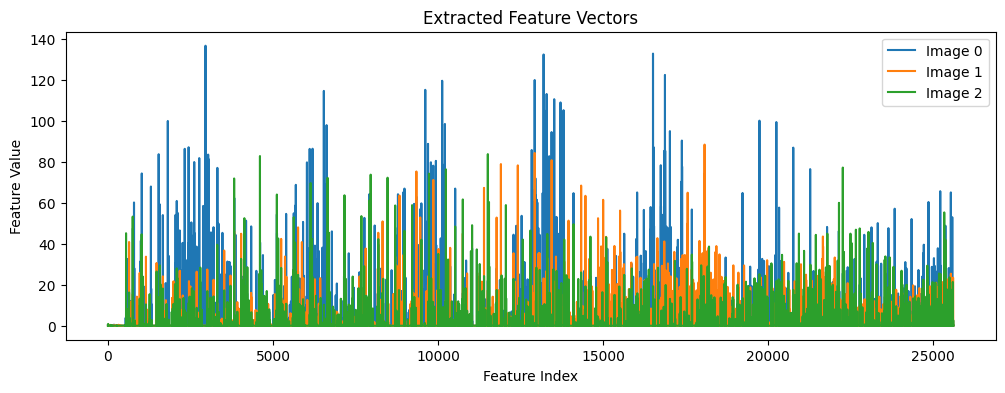

In [ ]:
import seaborn as sns

# Feature shape inspection
print("Feature shape per image:", X_features.shape)

# Visualize feature vector distribution for a few samples
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.plot(X_features[i], label=f"Image {i}")
plt.title("Extracted Feature Vectors")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.legend()
plt.show()

In [ ]:
# ======================
# 3. Feature Selection Module
# ======================
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier

def select_features_filter(X, y, k=300):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    print(f"Selected {X_selected.shape[1]} features using SelectKBest.")
    return X_selected, selector

def select_features_rfe(X, y, k=300):
    estimator = RandomForestClassifier(n_estimators=100, random_state=42)
    selector = RFE(estimator, n_features_to_select=k, step=50, verbose=1)
    X_selected = selector.fit_transform(X, y)
    print(f"Selected {X_selected.shape[1]} features using RFE.")
    return X_selected, selector

use_rfe = True  # Toggle to True to use RFE
if use_rfe:
    X_selected, feature_selector = select_features_rfe(X_features, y_labels, k=300)
else:
    X_selected, feature_selector = select_features_filter(X_features, y_labels, k=300)

Fitting estimator with 25609 features.
Fitting estimator with 25559 features.
Fitting estimator with 25509 features.
Fitting estimator with 25459 features.
Fitting estimator with 25409 features.
Fitting estimator with 25359 features.
Fitting estimator with 25309 features.
Fitting estimator with 25259 features.
Fitting estimator with 25209 features.
Fitting estimator with 25159 features.
Fitting estimator with 25109 features.
Fitting estimator with 25059 features.
Fitting estimator with 25009 features.
Fitting estimator with 24959 features.
Fitting estimator with 24909 features.
Fitting estimator with 24859 features.
Fitting estimator with 24809 features.
Fitting estimator with 24759 features.
Fitting estimator with 24709 features.
Fitting estimator with 24659 features.
Fitting estimator with 24609 features.
Fitting estimator with 24559 features.
Fitting estimator with 24509 features.
Fitting estimator with 24459 features.
Fitting estimator with 24409 features.
Fitting estimator with 24

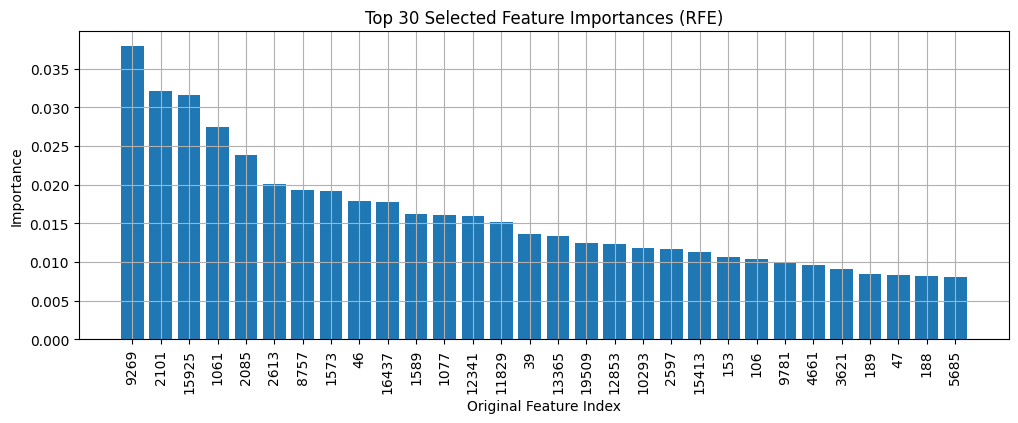

In [ ]:
# Get importances of selected features
selected_indices = feature_selector.get_support(indices=True)  # Indices in full space
selected_importances = feature_selector.estimator_.feature_importances_  # Already in reduced space

# Create a mapping of original index → importance
importance_dict = {idx: imp for idx, imp in zip(selected_indices, selected_importances)}

# Sort by importance
sorted_items = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
top_k = sorted_items[:30]  # Top 30 features

# Prepare for plotting
feature_ids = [idx for idx, _ in top_k]
importances = [imp for _, imp in top_k]

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.bar(range(len(feature_ids)), importances, tick_label=feature_ids)
plt.title("Top 30 Selected Feature Importances (RFE)")
plt.xlabel("Original Feature Index")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

Accuracy: 0.9600
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.91        49
           1       0.96      0.99      0.97       151

    accuracy                           0.96       200
   macro avg       0.97      0.93      0.94       200
weighted avg       0.96      0.96      0.96       200



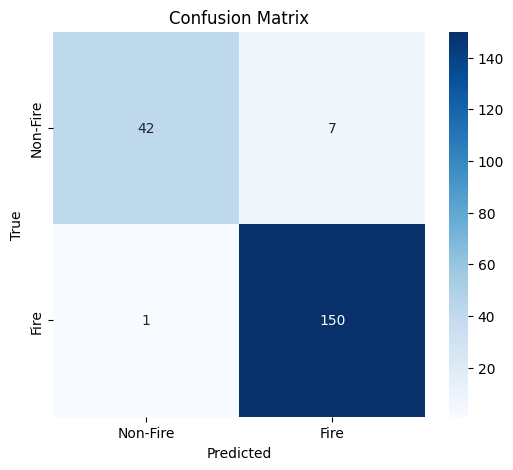

In [ ]:
# ======================
# 4. Model Training & Evaluation Module
# ======================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X_selected, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fire', 'Fire'], yticklabels=['Non-Fire', 'Fire'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()